In [717]:
from skimage import io
import cv2 as cv2
from PIL import Image
import numpy as np
import os
import shutil

In [718]:
from datasets import load_dataset
ds = load_dataset("F1nn21/playing-cards")

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(ds['train'][0])

In [ ]:
# Extract the image from the dataset
import matplotlib.pyplot as plt

# Convert the image to a format that can be displayed with matplotlib
image = ds['train'][0]['image']
plt.imshow(image)
plt.axis('off')  # Hide the axis


In [ ]:
fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Display just a part of the image
cropped_image = image.crop((15, 30, 100, 230))
plt.imshow(cropped_image)
plt.show()

In [ ]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        rect = Rectangle((15, 30), 100, 230, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


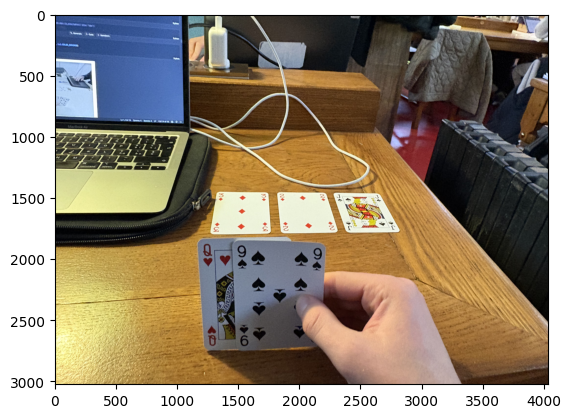

In [ ]:
image_path = "../IMG_0030.jpeg"

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
def rgb2gray(img):
    gray = img.copy()
    gray[:, :, 0] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 1] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 2] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    return gray

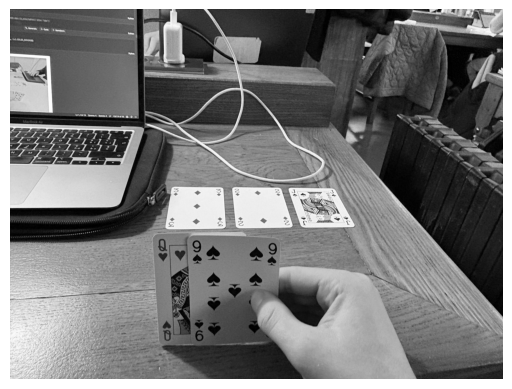

In [ ]:
gray = rgb2gray(image)
plt.imshow(gray)
plt.axis('off')
plt.show()

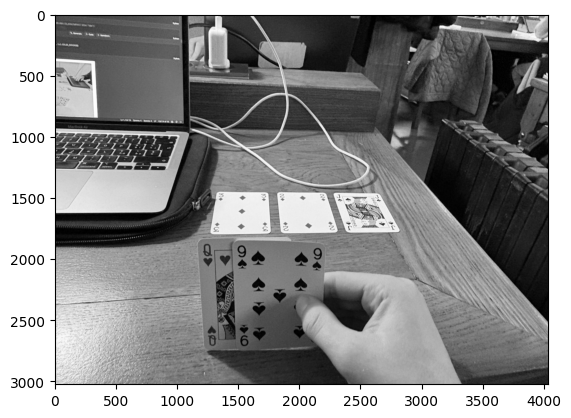

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred)

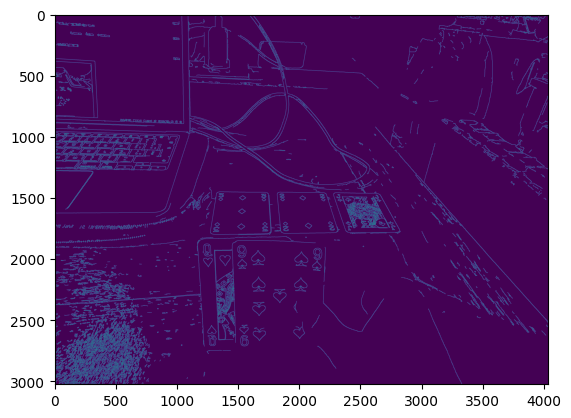

In [ ]:
edges = cv2.Canny(blurred, 50, 150)
plt.imshow(edges)

In [ ]:
from matplotlib.animation import FuncAnimation

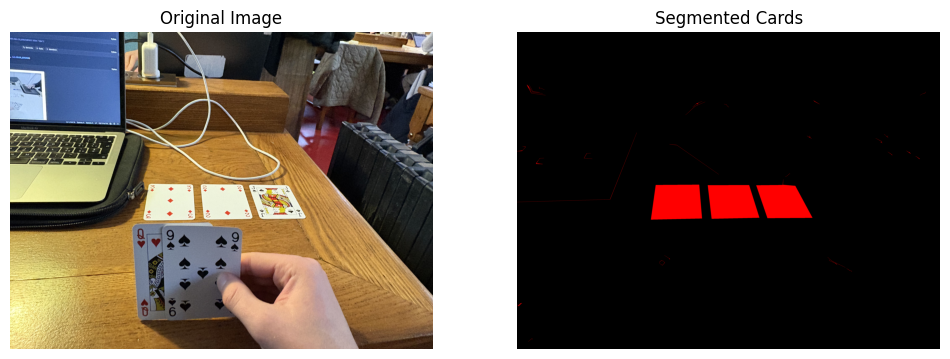

In [ ]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(gray)
A_list = []
for contour in contours:

    epsilon = 0.02 * cv2.arcLength(contour, True)
    poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

    if 4 <= len(poly) <= 8: # Becuase of approximation we check if the polygon has a number of polygons between 4 and 8
        x, y, w, h = cv2.boundingRect(poly) 
        aspect_ratio = w / float(h)
        A = w * h

        if A >= 1000 and 1.3 <= aspect_ratio <= 1.8:
            cv2.drawContours(mask, [poly], -1, 255, -1) 


plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Segmented Mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmented Cards")
plt.axis('off')

plt.show()


In [ ]:
path_name = '../shared_data/kaggle_playing_card_ataset/Images/Images/'

In [ ]:
img_paths = []
for filename in os.listdir(path_name):
    if filename.endswith(".jpg"):
        img_path = path_name + filename
        img_paths.append(img_path)

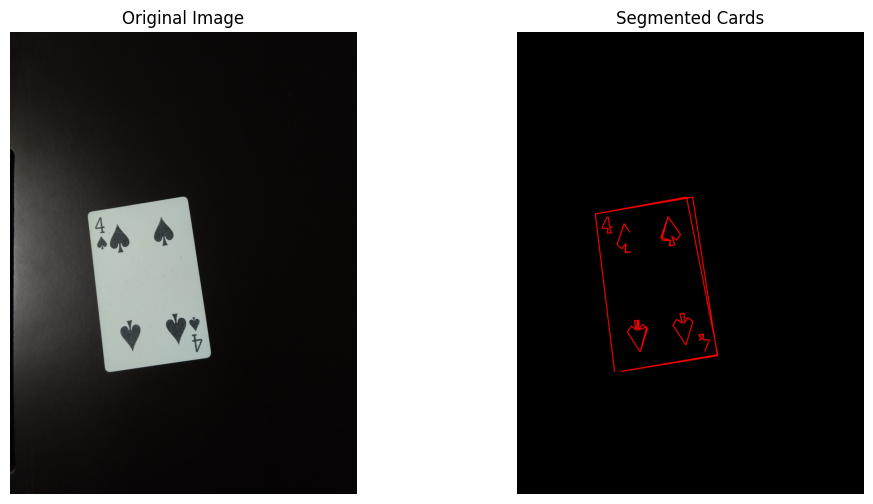

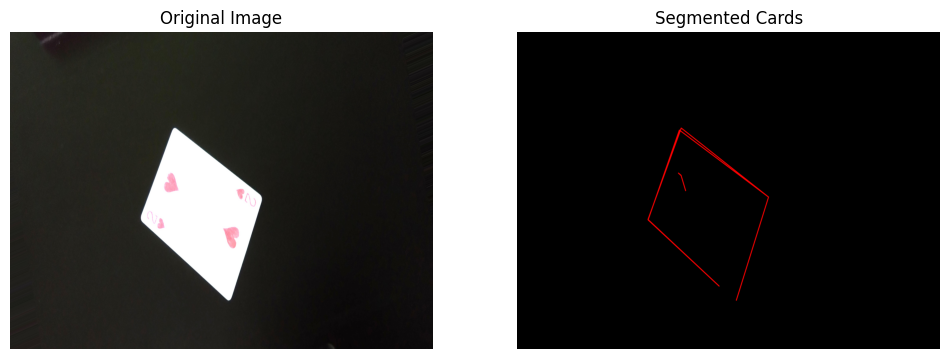

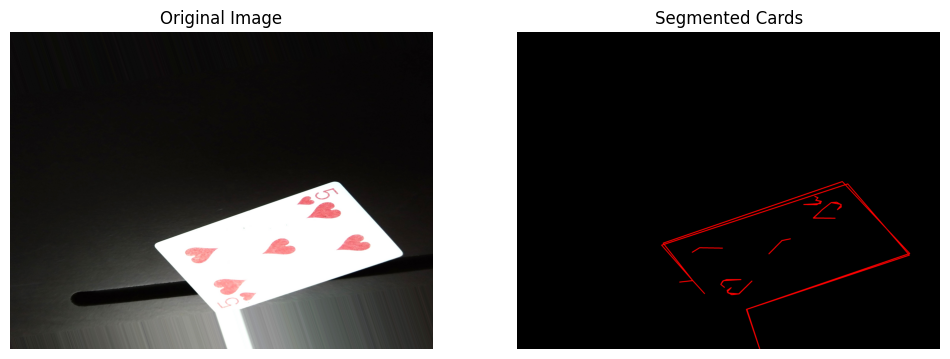

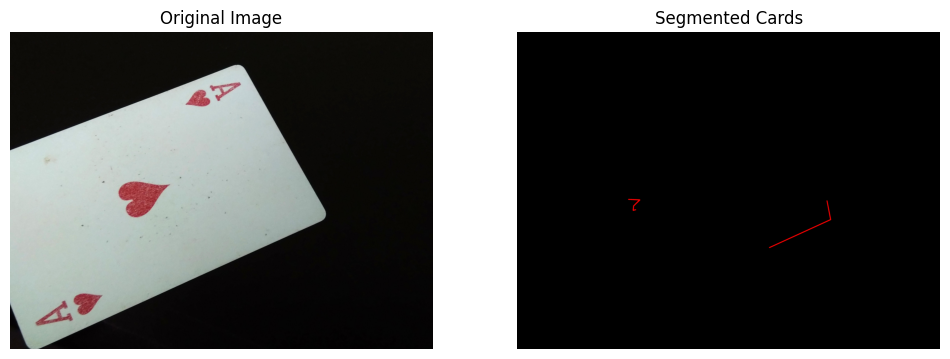

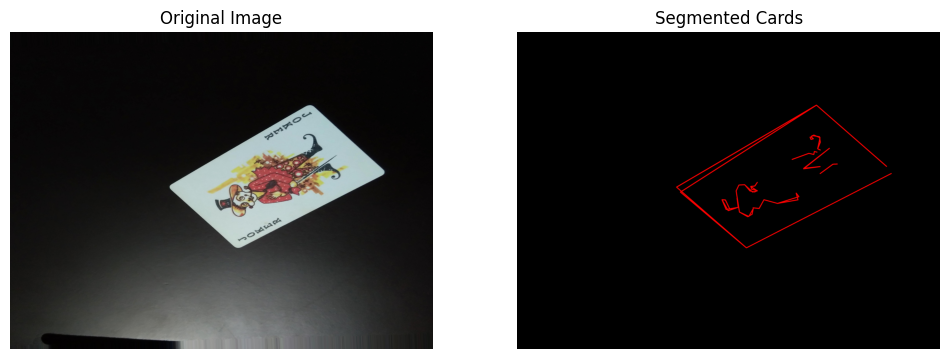

In [ ]:
def segment_cards(image_path:str, plot:bool=True) -> np.array:

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)
    warped_cards = []
    for contour in contours:

        epsilon = 0.02 * cv2.arcLength(contour, True)
        poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

        if:
            _, _, w, h = cv2.boundingRect(poly) 
            aspect_ratio = w / float(h)
            if w * h < 15000: continue

            # if 1 <= aspect_ratio <= 1.8 and 0.8 <= extent <= 1.0:
            cv2.drawContours(mask, [poly], -1, 255, 10) 
            pts = np.array([poly[i][0] for i in range(4)], dtype="float32")
            dst = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype="float32")
            M = cv2.getPerspectiveTransform(pts, dst)
            warped = cv2.warpPerspective(img, M, (w, h))
            warped_cards.append(warped)

    if plot:
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Segmented Mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmented Cards")
        plt.axis('off')

        plt.show()
    
    return mask

for path in img_paths[:5]:
    _ = segment_cards(path)

# Syntetic data generation

In [2]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def background_card_images(backgrounds_dir:str, cards_dir:str):
    backgrounds = [os.path.join(backgrounds_dir, f) for f in os.listdir(backgrounds_dir) if f.endswith('.jpg')]
    cards = [os.path.join(cards_dir, f) for f in os.listdir(cards_dir) if f.endswith('.png')]
    return backgrounds, cards

In [3]:
def add_padding(card, padding):
    h, w, _ = card.shape

    new_h = h + 2*(padding)
    new_w = w + 2*(padding)

    padded_card = np.zeros((new_h, new_w, 4), dtype=np.uint8)
    padded_card[padding:padding+h, padding:padding+w] = card

    return padded_card

In [4]:
def warp_perspective(card, src_points, dst_points):
    h, w, _ = card.shape

    perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_card = cv2.warpPerspective(card, perspective_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

    return warped_card

In [5]:
def rotation(card, angle):
    h, w, _ = card.shape
    center = (w//2, h//2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_card = cv2.warpAffine(card, rotation_matrix, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))

    return rotated_card

In [6]:
def place_hand(background_sample, hand_samples, offset, angle, class_map):

    # Load the images
    bkg = cv2.cvtColor(cv2.imread(background_sample), cv2.COLOR_BGR2RGB)
    hand1 = cv2.cvtColor(cv2.imread(hand_samples[0]), cv2.COLOR_BGR2RGBA)
    hand2 = cv2.cvtColor(cv2.imread(hand_samples[1]), cv2.COLOR_BGR2RGBA)

    # Extract the labels
    label1 = hand_samples[0][-6:-4]
    label2 = hand_samples[1][-6:-4]

    h, w, _ = hand1.shape

    # Define the source and distance points required for warping
    src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_points = np.float32([
        [-offset, 0],
        [w+offset, 0],
        [w, h],
        [0, h]                       
    ])

    # Define the second hand angle based on the first hand
    angle2 = angle + np.random.choice([1, -1]) * np.random.normal(0, 2)
    # Define the resized dimensions of the cards
    new_w = int(np.random.normal(150, 10))
    new_h = int(new_w*1.3)

    # Add padding, apply warping and rotation
    hand1 = add_padding(hand1, offset+100)
    hand1 = warp_perspective(hand1, src_points, dst_points)
    hand1 = rotation(hand1, angle)
    hand2 = add_padding(hand2, offset+100)
    hand2 = warp_perspective(hand2, src_points, dst_points)
    hand2 = rotation(hand2, angle2)
    #Resize the cards
    hand1 = cv2.resize(hand1, (new_w, new_h), interpolation=cv2.INTER_AREA)
    hand2 = cv2.resize(hand2, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Define the position of the cards on the background
    x1 = np.random.randint(100, bkg.shape[1]-100)
    x2 = int(x1 * (1 + np.random.uniform(0.7, 1)*new_w*(1 if x1 < 320 else -1)/640)) # Place the second card on the left or right of the first one
    y = np.random.randint(320, 380)

    bounding_boxes = []
    combined_bbox = [float("inf"), float("inf"), float("-inf"), float("-inf")] 

    # Place the cards on the background
    for card, pos, label in zip([hand1, hand2], [(x1, y), (x2, y)], [label1, label2]):
        x, y = pos
        h, w, _ = card.shape

        # Crop the image to take the smallest bouding box
        non_transparent = np.argwhere(card[:, :, 3] > 0)
        y_min, x_min = non_transparent.min(axis=0)
        y_max, x_max = non_transparent.max(axis=0)
        global_x_min = x + x_min
        global_y_min = y + y_min
        global_x_max = x + x_max
        global_y_max = y + y_max

        # Update combined bounding box
        combined_bbox[0] = min(combined_bbox[0], global_x_min)
        combined_bbox[1] = min(combined_bbox[1], global_y_min)
        combined_bbox[2] = max(combined_bbox[2], global_x_max)
        combined_bbox[3] = max(combined_bbox[3], global_y_max)

        # Normalize for YOLO and store individual bounding boxes
        x_center = (global_x_min + global_x_max) / 2 / bkg.shape[1]
        y_center = (global_y_min + global_y_max) / 2 / bkg.shape[0]
        w_normalized = (global_x_max - global_x_min) / bkg.shape[1]
        h_normalized = (global_y_max - global_y_min) / bkg.shape[0]

        label = class_map[label]

        bounding_boxes.append(f"{label} {x_center:.6f} {y_center:.6f} {w_normalized:.6f} {h_normalized:.6f}")

        for c in range(3):
            bkg[y:y+h, x:x+w, c] = (
                card[:, :, c] * (card[:, :, 3] / 255.0) +
                bkg[y:y+h, x:x+w, c] * (1.0 - card[:, :, 3] / 255.0)
            )
    
    combined_x_center = (combined_bbox[0] + combined_bbox[2]) / 2 / bkg.shape[1]
    combined_y_center = (combined_bbox[1] + combined_bbox[3]) / 2 / bkg.shape[0]
    combined_width = (combined_bbox[2] - combined_bbox[0]) / bkg.shape[1]
    combined_height = (combined_bbox[3] - combined_bbox[1]) / bkg.shape[0]
    bounding_boxes.append(f"{class_map['hand']} {combined_x_center:.6f} {combined_y_center:.6f} {combined_width:.6f} {combined_height:.6f}")

    return bkg, bounding_boxes

In [7]:
def place_table_cards(hand, card_samples, offset, class_map, bounding_boxes):
    bkg = hand.copy()

    # Load card images
    cards = [cv2.cvtColor(cv2.imread(card), cv2.COLOR_BGR2RGBA) for card in card_samples[2:]]
    if not cards:
        return bkg, bounding_boxes

    n = len(cards)

    # Extract the labels
    labels = [card[-6:-4] for card in card_samples[2:]]

    # Card dimensions after resizing
    new_w = int(np.random.normal(120, 10))
    new_h = int(new_w * 1.3)

    # Apply transformations to each card
    for i in range(len(cards)):
        cards[i] = add_padding(cards[i], offset + 100)
        h, w, _ = cards[i].shape
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        dst_points = np.float32([
            [offset, 0],
            [w - offset, 0],
            [w, h],
            [0, h]
        ])
        angle = np.random.normal(0, 5)
        cards[i] = warp_perspective(cards[i], src_points, dst_points)
        cards[i] = rotation(cards[i], angle)

        cards[i] = cv2.resize(cards[i], (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Place the canvas onto the background
    x = np.random.randint(100, bkg.shape[1] - 4*new_w)
    y = np.random.randint(100, 250)

    positions = [((int(x + i*new_w//2), y)) for i in range(n)]
    combined_bbox = [float("inf"), float("inf"), float("-inf"), float("-inf")]

    # Blend canvas onto the background
    for card, pos, label in zip(cards, positions, labels):
        x, y = pos
        h, w, _ = card.shape

        # Compute bounding box based on non-transparent pixels
        non_transparent = np.argwhere(card[:, :, 3] > 0)
        y_min, x_min = non_transparent.min(axis=0)
        y_max, x_max = non_transparent.max(axis=0)

        # Convert bounding box to global coordinates
        global_x_min = x + x_min
        global_y_min = y + y_min
        global_x_max = x + x_max
        global_y_max = y + y_max

        # Update combined bounding box
        combined_bbox[0] = min(combined_bbox[0], global_x_min)
        combined_bbox[1] = min(combined_bbox[1], global_y_min)
        combined_bbox[2] = max(combined_bbox[2], global_x_max)
        combined_bbox[3] = max(combined_bbox[3], global_y_max)

        # Normalize for YOLO and store individual bounding boxes
        x_center = (global_x_min + global_x_max) / 2 / bkg.shape[1]
        y_center = (global_y_min + global_y_max) / 2 / bkg.shape[0]
        width = (global_x_max - global_x_min) / bkg.shape[1]
        height = (global_y_max - global_y_min) / bkg.shape[0]

        label = class_map[label]

        bounding_boxes.append(f"{label} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        for c in range(3):
            bkg[y:y+h, x:x+w, c] = (
                card[:h, :w, c] * (card[:h, :w, 3] / 255.0) +
                bkg[y:y+h, x:x+w, c] * (1.0 - card[:h, :w, 3] / 255.0)
            )

    if n == 3:
        table_label = class_map['flop']
    elif n == 4:
        table_label = class_map['turn']
    else:
        table_label = class_map['river']

    combined_x_center = (combined_bbox[0] + combined_bbox[2]) / 2 / bkg.shape[1]
    combined_y_center = (combined_bbox[1] + combined_bbox[3]) / 2 / bkg.shape[0]
    combined_width = (combined_bbox[2] - combined_bbox[0]) / bkg.shape[1]
    combined_height = (combined_bbox[3] - combined_bbox[1]) / bkg.shape[0]
    bounding_boxes.append(f"{table_label} {combined_x_center:.6f} {combined_y_center:.6f} {combined_width:.6f} {combined_height:.6f}")

    return bkg, bounding_boxes

In [8]:
class_map ={'2C': 0, '2D': 1, '2H': 2, '2S': 3,
            '3C': 4, '3D': 5, '3H': 6, '3S': 7,
            '4C': 8, '4D': 9, '4H': 10, '4S': 11, 
            '5C': 12, '5D': 13, '5H': 14, '5S': 15, 
            '6C': 16, '6D': 17, '6H': 18, '6S': 19, 
            '7C': 20, '7D': 21, '7H': 22, '7S': 23, 
            '8C': 24, '8D': 25, '8H': 26, '8S': 27,
            '9C': 28, '9D': 29, '9H': 30, '9S': 31,
            'AC': 32, 'AD': 33, 'AH': 34, 'AS': 35, 
            'JC': 36, 'JD': 37, 'JH': 38, 'JS': 39, 
            'KC': 40, 'KD': 41, 'KH': 42, 'KS': 43, 
            'QC': 44, 'QD': 45, 'QH': 46, 'QS': 47,
            'TC': 48, 'TD': 49, 'TH': 50, 'TS': 51,
            'hand': 52, 'flop': 53, 'turn': 54, 'river': 55}

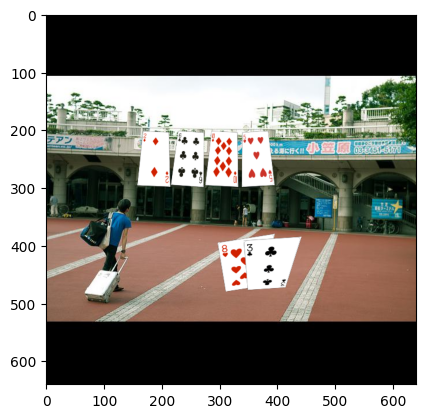

In [31]:
backgrounds_dir = './background'
cards_dir = '../shared_data/benchmark'

offset_hand = int(np.random.normal(200, 20))
offset_table = int(np.random.normal(200, 20))
angle_hand = np.random.normal(0, 7)

backgrounds, cards = background_card_images(backgrounds_dir, cards_dir)

bkg_sample = np.random.choice(backgrounds)

n_cards = 2
if random.random() > 0.2:
    n_cards += 3
    if random.random() > 0.5:
        n_cards += 1
        if random.random() > 0.6:
            n_cards += 1

card_samples = np.random.choice(cards, n_cards, replace=False)

hand, bounding_boxes = place_hand(bkg_sample, card_samples, offset_hand, angle_hand, class_map)
hand_table, bounding_boxes = place_table_cards(hand, card_samples, offset_table, class_map, bounding_boxes)
plt.imshow(hand_table)
plt.show()

In [ ]:
def visualize_yolo_bounding_boxes(image, yolo_bounding_boxes, class_names=None):
    """
    Visualizes bounding boxes from YOLO format on an image.
    
    Parameters:
        image_path (str): Path to the image file.
        yolo_bounding_boxes (list): List of YOLO bounding boxes in the format:
                                    [<class_id> <x_center> <y_center> <width> <height>]
        class_names (list, optional): List of class names corresponding to class IDs.
                                       If None, only class IDs are displayed.
    """
    # Load the image
    h, w, _ = image.shape
    
    # Iterate through each bounding box
    for bbox in yolo_bounding_boxes:
        bbox_parts = bbox.split()
        class_id = int(bbox_parts[0])
        x_center = float(bbox_parts[1])
        y_center = float(bbox_parts[2])
        box_width = float(bbox_parts[3])
        box_height = float(bbox_parts[4])
        
        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        
        # Draw the rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
        
        # Add the class label
        value = 30 if class_id >= 52 else 0
        label = f"{class_names[class_id] if class_names else class_id}"
        cv2.putText(image, label, (x1 - value, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [32]:
def generate_yolo_dataset(output_dir, backgrounds_dir, cards_dir, n_images, class_map):

    image_dir = os.path.join(output_dir, "images")
    label_dir = os.path.join(output_dir, "labels")
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in tqdm(range(n_images), desc=f"Generating {output_dir}"):

        backgrounds, cards = background_card_images(backgrounds_dir, cards_dir)
        
        n_cards = 2
        if random.random() > 0.2:
            n_cards += 3
            if random.random() > 0.5:
                n_cards += 1
                if random.random() > 0.6:
                    n_cards += 1
        
        bkg_sample = np.random.choice(backgrounds)
        card_samples = np.random.choice(cards, n_cards, replace=False)

        try:
            hand_bkg, bb_hand = place_hand(bkg_sample, 
                                           card_samples, 
                                           offset_hand, 
                                           angle_hand, 
                                           class_map)
            final_image, bb_final = place_table_cards(hand_bkg, 
                                                      card_samples, 
                                                      offset_table, 
                                                      class_map, 
                                                      bb_hand)
            
            image_path = os.path.join(image_dir, f"image_{i:04d}.jpg")
            label_path = os.path.join(label_dir, f"image_{i:04d}.txt")

            cv2.imwrite(image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
            with open(label_path, "w") as label_file:
                label_file.write("\n".join(bb_final))
        except:
            continue
            

In [36]:
train_path = './synthetic_dataset/train'
val_path = './synthetic_dataset/val'
test_path = './synthetic_dataset/test'

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

generate_yolo_dataset(train_path, backgrounds_dir, cards_dir, 15_000, class_map)
generate_yolo_dataset(val_path, backgrounds_dir, cards_dir, 2_500, class_map)
generate_yolo_dataset(test_path, backgrounds_dir, cards_dir, 2_500, class_map)

Generating ./synthetic_dataset/test: 100%|██████████| 2500/2500 [12:26<00:00,  3.35it/s]
